# LLM detection
## Assignment #3
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Data Augmentation

We begin by reviewing the data provided to us by the competition:

In [1]:
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import os


# enable progress bar functionality
tqdm_notebook().pandas()

DATA_DIR = os.path.join("..", "data")

0it [00:00, ?it/s]

In [2]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Out of these we have been provided with only 3 generated essays:

In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


### Prompting

Unless we procure more data the task is impossible. We will thus use prompting to produce our own generated dataset.

For this task we will use ChatGPT. The prompts were manually given using the official website, and exported the responses in MarkDown form using the very convinient [ChatGPT Conv Down](https://addons.mozilla.org/en-US/firefox/addon/chatgpt-convdown/) Firefox addon. 

We used three prompting strategies to procure our generated dataset:
* The standard prompt (used for the human essays) without sources
* The standard prompt using all the sources, with a role prompt to persuade the model into writing in a more simplistic tone mirroring the tone used in the human essays
* The standard prompt with a role prompt, using a different subset of the sources each time 
* The standard prompt with a role prompt and a different subset of the human essays instead of sources, in order to "mimick" the tone and style of these essays

This procedure was repeated for both types of prompts provided in the dataset (car-free cities and the Electoral College). The conversation context was periodically refreshed in order to avoid the model repeating its own generated essays. Following this procedure we hope to obtain a thorough dataset being as close as possible to the actual operational dataset.

Details on the prompts themselves can be found in `report.pdf`.

### Dataset Caveats

Unfortunately, even following the above strategy does not yield as good results as we would hope for. The biggest isse by far is that ChatGPT's output is formulaic and carries a distinct tone which is most of the time distinct from the students'. 

Role prompting and including human essays as input slightly alleviates the problem but does not eradicate it. Trying to explictly set the tone of the generated essays leads to a complete collapse in tone, with outputs as *artistic* as the one below:

>Dear [Senator's Name],
>
>Hope this letter finds you chill. I wanted to throw my two cents into the mix about the whole Electoral College debate. It's like a hot topic, right? Some say we should keep it, others are all about switching to the popular vote. Here's where I'm at.
>
>So, keeping the Electoral College – it's got its quirks, but it's not all bad. I get it, voting for electors instead of the actual president seems a bit weird. But, like, it's been working, hasn't it? It's like a system our folks set up ages ago, and yeah, maybe it's not perfect, but it's got a rhythm." [...]


In [4]:
import os


OUTPUT_DIR = "..\output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")


def save_plot(filename: str) -> None:
    """
    Saves a plot to the output directory.

    :param filename: The name of the file for the Figure.
    :type filename: str
    """
    path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

### Importing the generated dataset

In [5]:
def read_gpt(file: str) -> pd.Series:
    """
    Read and extract ChatGPT responses from a file.

    :param file: A string specifying the name of the file to be read.
    :type file: str

    :return: A pandas Series containing ChatGPT responses extracted from the file.
    :rtype: pd.Series
    """
    with open(os.path.join(DATA_DIR, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


def create_dataset(text_row: pd.Series, prompt_id: int, llm:str, source: str):
    data_text = text_row
    df = pd.DataFrame({"id": [str(hash(text)) for text in data_text],
                     "text": data_text, 
                       "prompt_id": np.full_like(data_text, prompt_id),
                       "generated": np.ones_like(data_text),
                       "llm": llm,
                       "source": source})
    df.prompt_id = df.prompt_id.astype(int)
    df.generated = df.generated.astype(int)
    return df
    

envir_df = create_dataset(read_gpt("chatgpt_cars.md"), 
                          prompt_id=0, 
                          llm="ChatGPT", 
                          source="Dimitris Tsirmpas")
elect_df = create_dataset(read_gpt("chatgpt_electoral.md"),
                          prompt_id=1, 
                          llm="ChatGPT",
                          source="Dimitris Tsirmpas")

In [6]:
palm_car = pd.read_csv(os.path.join(DATA_DIR, "cars_generated.csv"))
palm_car_df = create_dataset(palm_car.text, 0, "PaLM",  "Konstantina Liagkou")
palm_car_df

,id,text,prompt_id,generated,llm,source
0,-520228841973214070,Cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou
1,6608331338134701053,"Limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou
2,7138188490374180722,"""America's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou
3,3084568973721699379,"Cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou
4,-4989392494283758830,"Cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
1370,5199782608534614807,**Limiting Car Usage**\r\n\r\nCars are a major...,0,1,PaLM,Konstantina Liagkou
1371,3151449556245304534,Limiting car usage has many advantages. For ex...,0,1,PaLM,Konstantina Liagkou
1372,6260845130129147622,Limiting car usage is a great way to improve o...,0,1,PaLM,Konstantina Liagkou
1373,-3181775063693854664,As we all know cars are a big part of our soci...,0,1,PaLM,Konstantina Liagkou


In [7]:
palm_elect = pd.read_csv(os.path.join(DATA_DIR, "elections_generated.csv"))
palm_elect_df = create_dataset(palm_elect.text, 1, "PaLM",  "Konstantina Liagkou")
palm_elect_df

,id,text,prompt_id,generated,llm,source
0,-4369432543614010707,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1,-3546644664226475740,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
2,138413290511,NaN,1,1,PaLM,Konstantina Liagkou
3,-3323582868116106533,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
4,5839161300826078431,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
1370,7790919404735588704,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1371,6963832717009720024,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1372,-207899474789322697,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou
1373,-5823322266313393705,"Dear Senator,\r\n\r\nI am writing to you today...",1,1,PaLM,Konstantina Liagkou


https://www.kaggle.com/datasets/kingki19/llm-generated-essay-using-palm-from-google-gen-ai

In [8]:
palm_general = pd.read_csv(os.path.join(DATA_DIR, "LLM_generated_essay_PaLM.csv"))
palm_general_df = create_dataset(palm_general.text, -1, "PaLM", "Muhammad Rizqi")
palm_general_df.prompt_id = palm_general.prompt_id.astype(int)
palm_general_df

,id,text,prompt_id,generated,llm,source
0,2418856000733125616,## The Advantages of Limiting Car Usage\n\nIn ...,0,1,PaLM,Muhammad Rizqi
1,-2218697404895280556,"The United States is a car-dependent nation, w...",0,1,PaLM,Muhammad Rizqi
2,8288726022357760732,"In recent years, there has been a growing move...",0,1,PaLM,Muhammad Rizqi
3,4566979365733092441,"In recent years, there has been a growing move...",0,1,PaLM,Muhammad Rizqi
4,3189953440424919485,"In the past few decades, the United States has...",0,1,PaLM,Muhammad Rizqi
...,...,...,...,...,...,...
1379,-1850039005927137236,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1380,-8827622929930052283,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1381,5135478849842366359,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi
1382,359601176995933715,"Dear Senator,\n\nI am writing to you today to ...",1,1,PaLM,Muhammad Rizqi


We will export the entire dataset, but will only use a subset of it in training. This is because of the low quality data encountered in the first prompts, where the generated texts do not match the tone or the contents of the human essays.

In [9]:
comp_df = train_df
comp_df["llm"] = np.where(comp_df.generated==1, "Unknown", "Human")
comp_df["source"] = "Competition"
comp_df

,id,prompt_id,text,generated,llm,source
0,0059830c,0,Cars. Cars have been around since they became ...,0,Human,Competition
1,005db917,0,Transportation is a large necessity in most co...,0,Human,Competition
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,Human,Competition
3,00940276,0,How often do you ride in a car? Do you drive a...,0,Human,Competition
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,Human,Competition
...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0,Human,Competition
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0,Human,Competition
1375,ffa247e0,0,There's a new trend that has been developing f...,0,Human,Competition
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0,Human,Competition


In [10]:
original_df = pd.concat([palm_car_df, 
                         palm_elect_df, 
                         palm_general_df,
                         envir_df, 
                         elect_df, 
                         comp_df], ignore_index=True)
original_df

,id,text,prompt_id,generated,llm,source
0,-520228841973214070,Cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou
1,6608331338134701053,"Limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou
2,7138188490374180722,"""America's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou
3,3084568973721699379,"Cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou
4,-4989392494283758830,"Cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
5816,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0,Human,Competition
5817,ff669174,Limiting car usage has many advantages. Such a...,0,0,Human,Competition
5818,ffa247e0,There's a new trend that has been developing f...,0,0,Human,Competition
5819,ffc237e9,As we all know cars are a big part of our soci...,0,0,Human,Competition


In [11]:
original_df.text = original_df.text.dropna()

In [12]:
def try_str(x):
    try:
        x.strip()
        return True
    except:
        return False

mask = ~ original_df.text.apply(try_str)
original_df[mask]

,id,text,prompt_id,generated,llm,source
8,138413290511,NaN,0,1,PaLM,Konstantina Liagkou
10,138413290511,NaN,0,1,PaLM,Konstantina Liagkou
26,138413290511,NaN,0,1,PaLM,Konstantina Liagkou
28,138413290511,NaN,0,1,PaLM,Konstantina Liagkou
30,138413290511,NaN,0,1,PaLM,Konstantina Liagkou
...,...,...,...,...,...,...
2723,138413290511,NaN,1,1,PaLM,Konstantina Liagkou
2725,138413290511,NaN,1,1,PaLM,Konstantina Liagkou
2732,138413290511,NaN,1,1,PaLM,Konstantina Liagkou
2736,138413290511,NaN,1,1,PaLM,Konstantina Liagkou


In [13]:
original_df = original_df[~mask]

### Preprocessing

We execute the following preprocessing steps:
* Remove all placeholder tags such as [Your Name], and which are exclusively used by ChatGPT
* Turn all text to lowercase
* Remove stopwords

In [14]:
df = original_df.copy()

In [15]:
import re


def preprocess(text: pd.Series) -> pd.Series:
    bracket_regex = r"\[.*?\]"
    text = text.apply(lambda x: re.sub(bracket_regex, "", x))
    
    text = text.apply(lambda x: x.lower())
    
    return text

In [16]:
df.text = preprocess(df.text)

The resulting text resembles the following:

In [17]:
print(f"Number of generated essays in the dataset: {(df.generated == 1).sum()}")

Number of generated essays in the dataset: 3878


In [18]:
# check for null values
df.isnull().values.any()

False

We also may need to convert the dataframe's types.

### More augmentation?

Another idea would be to use other standard NLP augmentation techniques such as randomly deleting/inserting words, purposefully inserting typographical mistakes in the text or even [replacing words with close synonyms](https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement). However, all of these strategies would ultimately hurt the quality of our dataset, since typos and specific words are very valuable tools in LLM detection.

## Classifiers

In this section we train multiple classifiers on our data. 

Before we begin we must select an appropriate text representation, since our classifiers only work with numerical vectors, not strings. The two implementations that we use are:
* TF-IDF vectors
* Word2Vec embeddings

Both approaches have upsides and downsides. TF-IDF vectors are adept at automatically selecting features by weighting, assinging more importance to rare words. Word2Vec vectors on the other hand are dense document embeddings which take into account the semantic meaning of the words and not just their frequency. The downside is their fixed size (300x1 embedding for any word), which means that we either need to concatenate the vectors of each word in the text, or use a merging scheme in order to produce a document embedding from the individual word embeddings. In this study, we use the default Word2Vec behavior, which averages the word embeddings. While powerful, this technique may lead to significant data loss and overfitting if we are not sure the document embeddings of the train set are similar to the operational set (the data our algorithms will be run on and which aren't included in the train and test sets).

The goal is to use the simplest model possible that has an acceptably efficient performance. We start with discriminant classifiers such as **Naive Bayes** and **Logistic Regression** and consider Ensemble learning classifiers such as **Random Forest** and **Adaboost**. The results guide us on whether we would need to use more powerful NLP models such as RNNs, LSTMs or even (pretrained) Transformers. 

In [19]:
print("Downloading Word2Vec model...")

In [20]:
%%capture
!python -m spacy download en_core_web_md

In [21]:
print("Model downloaded.")

Model downloaded.


In [22]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def remove_stopwords(words: str) -> str:
    word_tokens = word_tokenize(words)
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)
    

def compute_embeddings(text: pd.Series, rem_stopwords: bool=True) -> list[str]:
    embeddings = []

    if remove_stopwords:
        print("Removing stopwords...")
        text = text.progress_apply(remove_stopwords)
    
    print("Computing embeddings...")
    for text in tqdm(text):
        embeddings.append(word2vec(text).vector)
        
    return embeddings

df["embedding"] = compute_embeddings(df.text, rem_stopwords=True)

Removing stopwords...


  0%|          | 0/5253 [00:00<?, ?it/s]

Computing embeddings...


  0%|          | 0/5253 [00:00<?, ?it/s]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_data_from_text(vectorizer: TfidfVectorizer, 
                       data_train: pd.DataFrame, 
                       data_test: pd.DataFrame) -> dict[str, np.ndarray]:
    vectorizer = vectorizer.fit(data_train.text)
    x_train = vectorizer.transform(data_train.text)
    x_test = vectorizer.transform(data_test.text)
    
    embed_x_train = np.array([x for x in data_train.embedding])
    embed_x_test = np.array([x for x in data_test.embedding])
    
    y_train = data_train.generated.values
    y_test = data_test.generated.values

    return {"x_train": x_train, 
            "y_train": y_train,
            "x_test": x_test, 
            "y_test": y_test, 
            "embed_x_train": embed_x_train, 
            "embed_x_test": embed_x_test}

In [32]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3, 
                                         stratify=df.generated,
                                         random_state=42)
#https://aclanthology.org/2020.aespen-1.6.pdf
vectorizer = TfidfVectorizer(strip_accents="unicode",
                             ngram_range=(3,5), 
                             max_df=0.9, 
                             min_df=0.05)
data = get_data_from_text(vectorizer, data_train, data_test)

x_train = data["x_train"]
x_test = data["x_test"]

embed_x_train = data["embed_x_train"]
embed_x_test = data["embed_x_test"]

y_train = data["y_train"]
y_test = data["y_test"]

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [33]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=5):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [34]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4247, std: 0.0002


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

Also note that Naive Bayes cannot be used on dense non-strictly-positive arrays, such as Word2Vec embeddings.

In [35]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, x_train, y_train)
print(f"Naive Bayes  with TF-IDF vectors Macro-F1 \n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes  with TF-IDF vectors Macro-F1 
 mean:0.9116, std: 0.0096


### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [36]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with TF-IDF vectors Macro-F1
 mean:0.9424, std: 0.0104


In [37]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")
    
    res = cross_val_res(lr, embed_x_train, y_train)
    print(f"Logistic Regression with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with Word2Vec Embeddings Macro-F1
 mean:0.9680, std: 0.0079


### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [38]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=500,
                                      criterion="entropy", 
                                      n_jobs=-1)
res = cross_val_res(forest_model, x_train, y_train)
print(f"Random Forest with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with TF-IDF vectors Macro-F1
 mean:0.9510, std: 0.0072


In [39]:
res = cross_val_res(forest_model, embed_x_train, y_train)
print(f"Random Forest with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with Word2Vec Embeddings Macro-F1
 mean:0.9633, std: 0.0055


### ExtraTreesClassifier

In [40]:
from sklearn.ensemble import ExtraTreesClassifier


extra_model = ExtraTreesClassifier(n_estimators=500, 
                                     max_depth=None,
                                     min_samples_split=0.05, 
                                   n_jobs=-1)
res = cross_val_res(extra_model, x_train, y_train)
print(f"Extra Trees Forest with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Extra Trees Forest with TF-IDF vectors Macro-F1
 mean:0.9450, std: 0.0109


In [41]:
res = cross_val_res(extra_model, embed_x_train, y_train)
print(f"Extra Trees Forest with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Extra Trees Forest with Word2Vec Embeddings Macro-F1
 mean:0.9505, std: 0.0069


### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [42]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=200)
res = cross_val_res(ada_model, x_train, y_train)
print(f"AdaBoost with TF-IDF vectors Macro-F1:\n mean {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with TF-IDF vectors Macro-F1:
 mean 0.9307, std: 0.0052


In [43]:
res = cross_val_res(ada_model, embed_x_train, y_train)
print(f"AdaBoost with Word2Vec Embeddings Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with Word2Vec Embeddings Macro-F1:
 mean:0.9657, std: 0.0079


### Results

From the scores above it's clear that the Adaboost classifier with TF-IDF embeddings outperforms the other classifiers. The model shows a (utopic?) macro-f1 training score of 1, which usually means it has overffited the training set. However the test set also displays an almost identical Macro-F1 score.

These results may be explained by how dissimilar our two classes are, which we already suspect is the case. Human essays feature typos and more casual and simple language, while LLM generated essays are formulaic, feature the same structure and often even the same formal vocabulary. This hypothesis will be tested in the next Section.

In [44]:
best_model = forest_model

In [45]:
from sklearn.model_selection import GridSearchCV


param_grid = [{"n_estimators": np.linspace(50, 2000, 10).astype(int)}]
search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=4)
search.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=500, n_jobs=-1),
             param_grid=[{'n_estimators': array([  50,  266,  483,  700,  916, 1133, 1350, 1566, 1783, 2000])}])

In [46]:
best_model = search.best_estimator_
best_pred = best_model.predict(x_test)
print(classification_report(y_test, best_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       413
           1       0.98      0.97      0.98      1163

    accuracy                           0.97      1576
   macro avg       0.95      0.96      0.96      1576
weighted avg       0.97      0.97      0.97      1576



### Interpreting the best model

In order to intrepret the decision making of our model we can use the `LimeTextExplainer` module which can show us a breakdown of the $n$ most important words which led to the classification of a text.

In [47]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=best_model.classes_)

Figured saved to ..\output\attribution.png


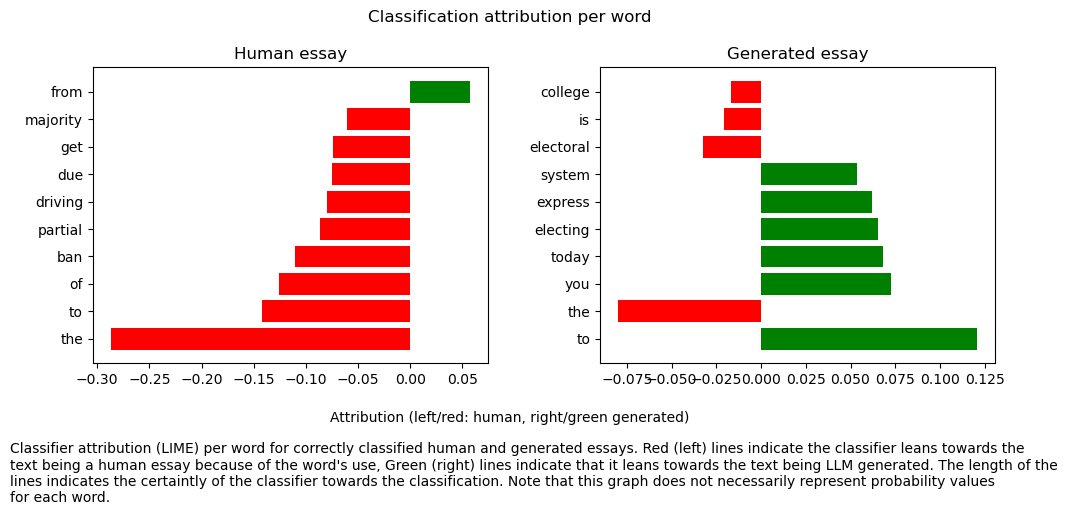

In [48]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].head(256)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].head(256)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

caption_text = "Classifier attribution (LIME) per word for correctly classified human and generated essays. "\
                "Red (left) lines indicate the classifier leans towards the text being a human essay "\
                "because of the word's use, Green (right) lines indicate that it leans towards the text being LLM generated. "\
                "The length of the lines indicates the certaintly of the classifier towards the classification. "\
                "Note that this graph does not necessarily represent probability values for each word."

caption = textwrap.fill(caption_text, width=150)
fig.text(0, -0.25, caption)

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (left/red: human, right/green generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3

save_plot("attribution.png")
plt.show()

The results don't make 

## Analyzing the dataset

### Text Similarity

Another step towards interpreting the results of our classifiers is to gauge the characteristics of our dataset. We can estimate how easily distinquishable the two classes (generated / human) are by calculating the similary between each generated post compared to all human ones.

There are many similarity scores for text data, each with its own criteria, strength and weaknesses. Two of the most prominent ones are:
* Cosine Similarity, usually used for text embeddings
* Jaccard Similarity, which is applied to the raw text, and calculates the ratio of common to total words between the texts. This score is biased towards large texts and does not take into account multiple instances of a word.

For the purposes of our analysis we use the Jaccard Similarity, since the TF-IDF representation that we have chosen inherently uses the existence of words instead of their semantic meaning. Thus, the Jaccard Similarity score should be directly related to the ability of our classifiers to distinguish the classes in our dataset.

We will be computing the mean and max similarity for every generated text compared to all human texts.

In [49]:
generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

In [50]:
def jaccard_similarity(set1: set[str], set2: set[str]) -> float:
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for x in tqdm(generated_df.text):
    similarities = []
    for y in human_df.text:
      similarities.append(jaccard_similarity(set(x.split()), set(y.split())))
                                        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

Calculating similarity scores...


  0%|          | 0/3878 [00:00<?, ?it/s]

In [51]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
0,-520228841973214070,cars have been a major part of our lives for a...,0.030534,0.063830
1,6608331338134701053,"limiting car usage has many advantages, such a...",0.116352,0.233607
2,7138188490374180722,"""america's love affair with it's vehicles seem...",0.032338,0.063415
3,3084568973721699379,"cars are convenient, but they can be harmful t...",0.050623,0.100000
4,-4989392494283758830,"cars are a convenient way to get around, but t...",0.118307,0.223108
...,...,...,...,...
4441,9025839832340890172,"dear ,\n\nhey, hope you're good! so, i've been...",0.120477,0.197101
4442,-8353329112198566341,"dear ,\n\nhope this letter finds you chill. i ...",0.121238,0.194079
5147,82131f68,"this essay will analyze, discuss and prove one...",0.128805,0.222222
5183,86fe4f18,i strongly believe that the electoral college ...,0.116595,0.227488


And plot the results, to get a better picture of the results:

Figured saved to ..\output\similarity.png


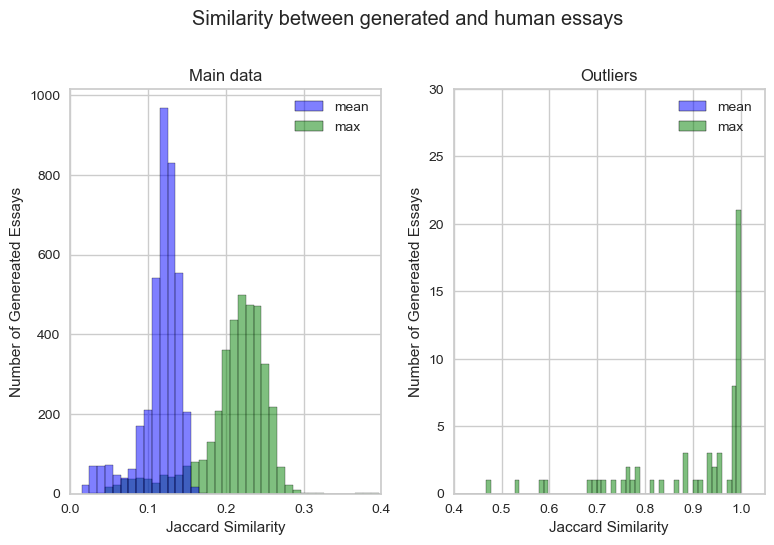

In [116]:
import seaborn as sns
import textwrap


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Similarity between generated and human essays")
fig.tight_layout(pad=2.0)

sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"}, ax=ax1)

#caption_text = """Mean and maximum Jaccard similarity between each generated essay compared to 
#all human essays. This Figure demonstrates the very low similarity between the two kinds of essays in 
#our dataset, laregely explaining the exceptional performance of our classifiers. 
#"""
#caption = textwrap.fill(caption_text, width=100)
#plt.figtext(-0.1, -0.2, caption)
ax1.set_xlim(0, 0.4)
ax1.set_xlabel("Jaccard Similarity")
ax1.set_ylabel("Number of Genereated Essays")
ax1.set_title("Main data")


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"}, ax=ax2)
ax2.set_xlabel("Jaccard Similarity")
ax2.set_ylabel("Number of Genereated Essays")
ax2.set_xlim(0.4)
ax2.set_ylim(0, 30)
ax2.set_title("Outliers")

save_plot("similarity.png")
plt.show()

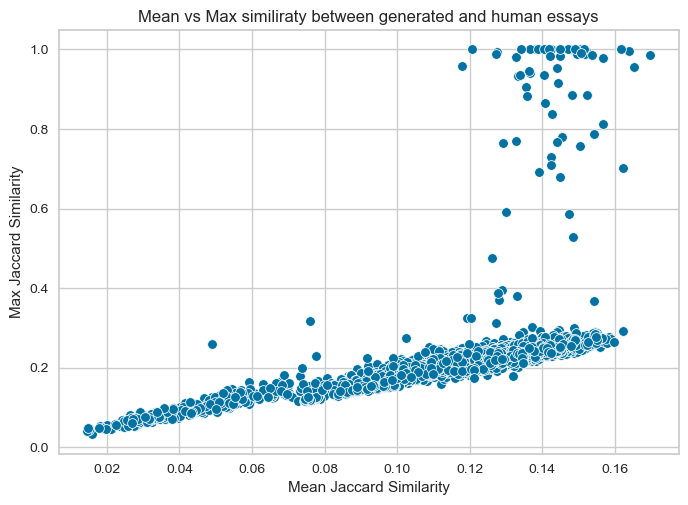

In [114]:
sns.scatterplot(x="mean", y="max", data=similarity_df)

plt.title("Mean vs Max similiraty between generated and human essays")
plt.xlabel("Mean Jaccard Similarity")
plt.ylabel("Max Jaccard Similarity")
plt.show()

In [53]:
outlier_df = df.merge(similarity_df[similarity_df["max"] > 0.9], how="inner", on="id")
outlier_df = outlier_df.drop("text_y", axis=1)
outlier_df = outlier_df.sort_values("max", ascending=False)
outlier_df.head(10)

,id,text_x,prompt_id,generated,llm,source,embedding,mean,max
15,6521521046565041079,limiting the usage of cars will bring a lot of...,0,1,PaLM,Konstantina Liagkou,"[-0.5782225, 0.24332923, -2.4579358, -0.452946...",0.147191,1.0
10,1904956897865106506,many people believe that it is necessary to us...,0,1,PaLM,Konstantina Liagkou,"[-0.33160272, -0.31828144, -1.7051255, -0.6998...",0.120713,1.0
24,-1457415086646915050,as we get older we want to travel to more plac...,0,1,PaLM,Konstantina Liagkou,"[-0.79505664, 0.9531083, -3.1073515, -0.625847...",0.141897,1.0
23,-952136852261464689,cars have always seemed to be a necessity to p...,0,1,PaLM,Konstantina Liagkou,"[-0.18551056, 0.36230952, -2.6442566, -0.78679...",0.150804,1.0
22,-2380871024690795606,cars are used for transporting from place to p...,0,1,PaLM,Konstantina Liagkou,"[-0.70787483, 0.46535164, -2.4349554, -0.22792...",0.161674,1.0
21,-4177886104101363422,"for years, the united states has been mass pro...",0,1,PaLM,Konstantina Liagkou,"[-0.48433185, 0.14956288, -2.5381866, -0.35953...",0.150053,1.0
19,4301073822774784290,imagine a world completely pollution free. a w...,0,1,PaLM,Konstantina Liagkou,"[-0.3619175, -0.03683313, -3.0423043, -0.35832...",0.142544,1.0
16,-6545231755830312027,the automobile has been a staple in human hist...,0,1,PaLM,Konstantina Liagkou,"[-0.5615728, 0.20120902, -2.315603, -0.6624788...",0.140410,1.0
34,8808871488883437406,"in the united states, people are very busy. wi...",0,1,PaLM,Konstantina Liagkou,"[-0.82555705, -0.14602426, -2.5105572, -0.1629...",0.149001,1.0
12,-3001507435126651076,"for decades, society has put a major emphasis ...",0,1,PaLM,Konstantina Liagkou,"[-0.96646154, -0.009873128, -2.183229, -0.4779...",0.138937,1.0


### Impact of data size

Lastly, we can look at the progressive learning curve of our classifier's performance to gauge the quality of our data.

We split the training data into $[10%, 20%, \cdots, 100%]$ random splits, leaving the test set whole. We then train our best classifier in all of the successive splits and keep the accuracy metric. 

In [65]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [data_train.sample(int(np.ceil(data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[368, 736, 1104, 1471, 1839, 2207, 2574, 2942, 3310, 3677]

In [66]:
from sklearn.metrics import f1_score


train_scores = []
test_scores = []

print("Running classifier on multiple training splits...")
for split in tqdm(splits):
    x_train = vectorizer.transform(split.text)
    y_train = split.generated
    model = clone(best_model)
    model = model.fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

  0%|          | 0/10 [00:00<?, ?it/s]

We now plot the accuracy metric (here Macro-F1 score for reasons outlined in the `Classifiers` section) in relation to the number of data points. 

A useful question would be how much data would we need to reach 100% test set accuracy. Since it's improbable that our classifier can reach this score with a reasonable amount of data we resort to using a regression plot on the test set accuracy metric. This has several caveats:
* The linearity assumption made by the (linear) regression plot is almost never accurate in training/test curves. The curves are oftentimes logarithmic, rapidly imporoving when only few data points exist, and plateauing after a certrain inflection point. For example, the performance of a classifier will improve more when we add 10 points from a previous dataset of 100, than if we add the same amount of points to a previous dataset of 10,000
* The shape of the curve will angle the regression line upwards since the first splits will almost certainly be much "lower" than the rest

Concluding, while we certainly can use a linear regression line to gauge the amount of data until we reach 100% test set accuracy, this prediction will almost certainly be overly optimistic.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figured saved to ..\output\dataset_size.png


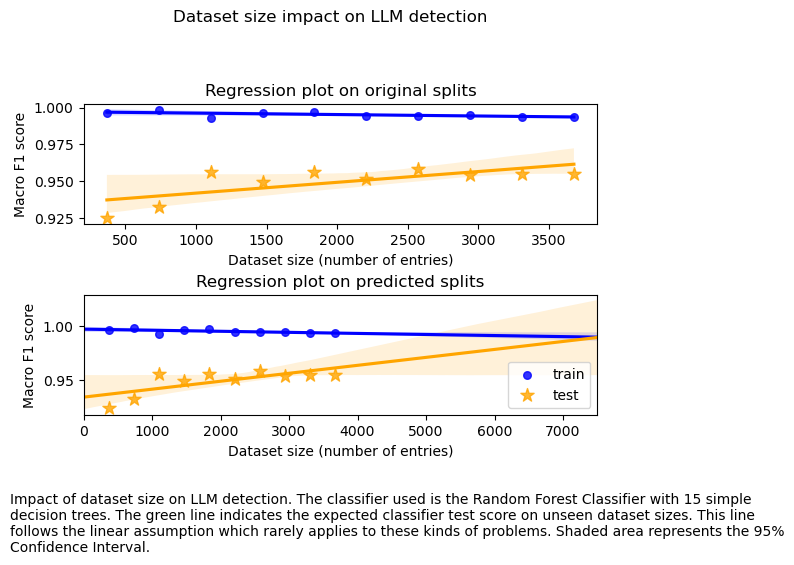

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Dataset size impact on LLM detection")
fig.tight_layout(pad=3)

# regular regplot
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax1,
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax1,
            scatter_kws={"s": 100})

ax1.set_title("Regression plot on original splits")
ax1.set_ylabel("Macro F1 score")
ax1.set_xlabel("Dataset size (number of entries)")
plt.legend()


# regplot with expanded xlim
plt.xlim(0, 7500)
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax2,
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax2,
            scatter_kws={"s": 100},
            truncate=False)

ax2.set_title("Regression plot on predicted splits")
ax2.set_ylabel("Macro F1 score")
ax2.set_xlabel("Dataset size (number of entries)")

# TODO: come back to this once done with data and classifiers
caption_text = "Impact of dataset size on LLM detection. The classifier used is the "\
"Random Forest Classifier with 15 simple decision trees. The green line indicates "\
"the expected classifier test score on unseen dataset sizes. This line follows the "\
"linear assumption which rarely applies to these kinds of problems. Shaded area represents "\
"the 95% Confidence Interval."
caption = textwrap.fill(caption_text, width=110)
plt.figtext(0, -0.15, caption)
plt.legend()

# save and show
save_plot("dataset_size.png")
plt.show()

### Leave-One-Out Cross Validation

By using LOOV-CV we can hopefully correlate the prediction probability of every generated text with its mean and max similarity with human texts, as described above.

#### Exporting intermediary data

The results do not surprise us, since as we saw from the classifier's Cross-Validation, training accuracy is very close to 100%. This is a consequence of our data and the problem at hand. Thus, we cannot run any meaningful analysis on the correlation between text similarity and probability.

In [54]:
import skops.io as sio


INTERMEDIATE_DIR = os.path.join("..", "intermediate")
print("Exporting model...")
sio.dump(best_model, os.path.join(INTERMEDIATE_DIR, "best_model.skops"))
print("Model exported")

Exporting model...
Model exported


In [55]:
df.to_csv(os.path.join(INTERMEDIATE_DIR, "loov_input_data.csv"))

In [62]:
res_df = pd.read_csv(os.path.join(INTERMEDIATE_DIR, "loov_res.csv"))
res_df = res_df.drop("Unnamed: 0", axis=1)
res_df.id = res_df.id.astype(str)

analysis_df = res_df.merge(similarity_df, 
                           how="inner", 
                           on="id", 
                           suffixes=("", "_x"))
analysis_df = analysis_df.drop("text_x", axis=1)
analysis_df

,id,text,proba,mean,max
0,4939831770751659793,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.125151,0.223529
1,-5181558583334583137,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.124485,0.267677
2,2366576317616977003,having to deal with traffic jams and having to...,1.000000,0.145804,0.248366
3,-1968555983985476503,**limiting car usage**\r\n\r\ncars are a conve...,1.000000,0.108858,0.183673
4,5004929736231301463,cars have become an essential part of our dail...,0.970580,0.126037,0.210031
...,...,...,...,...,...
602,-7965903384765500156,"dear senator,\r\n\r\ni am writing to you today...",0.999117,0.127327,0.235507
603,7537948682280034878,"dear state senator,\r\n\r\ni am writing to you...",0.994704,0.146585,0.262799
604,-3503307469460722422,"walk, bike, or take public transportation. dea...",0.998235,0.135283,0.247059
605,-2917229996352852675,"dear senator,\r\n\r\ni am writing to you today...",1.000000,0.131249,0.246862


Figured saved to ..\output\diversity_plot.png


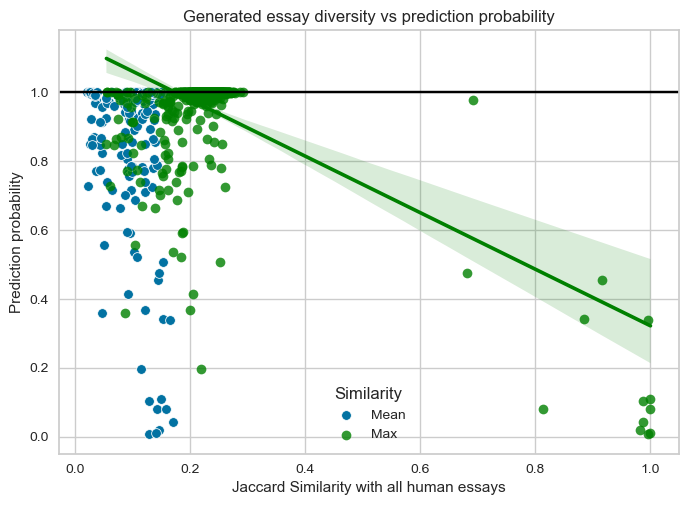

In [103]:
sns.scatterplot(x="mean", y="proba", data=analysis_df)
sns.regplot(x="max", y="proba", color="green", data=analysis_df)

plt.axhline(1, color="black")
plt.title("Generated essay diversity vs prediction probability")
plt.ylabel("Prediction probability")
plt.xlabel("Jaccard Similarity with all human essays")
plt.legend(title='Similarity', labels=['Mean', 'Max'], loc="lower center")

save_plot("diversity_plot.png")
plt.show()

### Selecting the optimal training dataset

In [68]:
df = df.merge(similarity_df.loc[:, ["id", "max"]], how="outer", on="id")
df = df[~(df["max"] > 0.95)]
df

,id,text,prompt_id,generated,llm,source,embedding,max
0,-520228841973214070,cars have been a major part of our lives for a...,0,1,PaLM,Konstantina Liagkou,"[0.08063801, 1.6982207, -2.530246, -0.46471617...",0.063830
1,6608331338134701053,"limiting car usage has many advantages, such a...",0,1,PaLM,Konstantina Liagkou,"[-0.8870298, -0.45862535, -3.3064713, -0.09198...",0.233607
2,7138188490374180722,"""america's love affair with it's vehicles seem...",0,1,PaLM,Konstantina Liagkou,"[0.9119747, 1.0349286, -1.5265588, -2.3698876,...",0.063415
3,3084568973721699379,"cars are convenient, but they can be harmful t...",0,1,PaLM,Konstantina Liagkou,"[-0.90010715, -0.37471777, -3.003909, -0.01778...",0.100000
4,-4989392494283758830,"cars are a convenient way to get around, but t...",0,1,PaLM,Konstantina Liagkou,"[-0.083860934, -0.271521, -3.4049506, -0.04745...",0.223108
...,...,...,...,...,...,...,...,...
5256,fe6ff9a5,there has been a fuss about the elector colleg...,1,0,Human,Competition,"[-1.4767352, 0.04409365, -2.265938, 0.2277243,...",NaN
5257,ff669174,limiting car usage has many advantages. such a...,0,0,Human,Competition,"[-0.20308205, 0.864372, -3.5353804, 0.25371215...",NaN
5258,ffa247e0,there's a new trend that has been developing f...,0,0,Human,Competition,"[-0.80689734, 0.0152280945, -2.0881786, -0.199...",NaN
5259,ffc237e9,as we all know cars are a big part of our soci...,0,0,Human,Competition,"[-0.65920925, 0.18932514, -2.4064806, -0.80102...",NaN


In [69]:
human_len = df[df.generated==0].shape[0]

new_generated = df[df.generated == 1].sort_values("max", ascending=False)[:human_len]
optimal_df = pd.concat([df[df.generated == 0], new_generated])
optimal_df = optimal_df.drop("max", axis=1)
optimal_df

,id,text,prompt_id,generated,llm,source,embedding
3883,0059830c,cars. cars have been around since they became ...,0,0,Human,Competition,"[-0.9639097, 0.15837152, -2.1686153, -0.057272..."
3884,005db917,transportation is a large necessity in most co...,0,0,Human,Competition,"[-1.2354518, -0.09898801, -2.1328986, 0.258718..."
3885,008f63e3,"""america's love affair with it's vehicles seem...",0,0,Human,Competition,"[-0.37253016, 0.15195324, -2.0611265, -0.86810..."
3886,00940276,how often do you ride in a car? do you drive a...,0,0,Human,Competition,"[-0.47272915, 0.18846808, -2.2762864, -0.72999..."
3887,00c39458,cars are a wonderful thing. they are perhaps o...,0,0,Human,Competition,"[-0.1297419, 0.26021686, -2.2862716, -0.554875..."
...,...,...,...,...,...,...,...
1601,6599161932490895477,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-2.0558875, -0.25538203, -1.84357, 0.7082762,..."
1411,7679157700243325056,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.5290718, -0.2343656, -1.7063466, 0.9458319..."
2050,1677614466269004755,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.7905977, -0.1608493, -1.6283364, 1.5226876..."
1353,-5646342049883425478,"dear senator,\r\n\r\ni am writing to you today...",1,1,PaLM,Konstantina Liagkou,"[-1.4043696, 0.193212, -1.7251533, 0.9179787, ..."


## Clustering-based augmentation

In order to determine the "variance" of our generated samples, we can use clustering techniques to determine in which groups the human and generated essays belong in. Using those groups we can extract their similarities by looking into their individual members, and determine which groups may be underrepresented in our dataset.

### Methodology

Before we execute the clustering algorithm we need to determine the number of clusters in our data. This can be either done by intuition (if we already know how many classes *should* exist according to our problem), or by statistical techniques.

Our intuition would lead us to choose $2$ clusters for both generated and human essays, one for each prompt. However, we are interested in seeing if there are underlying patterns within those two large clusters, which is why we need to use the afforementioned techniques.

There are two main methods we can use to determine the number of clusters, the **Elbow** method and the **Silhouette** score. To simplify, the Elbow method determines the last point at which the model improves significantly while the Silhouette score determines the cluster cohesion. 

We follow the advice of [this post](https://builtin.com/data-science/elbow-method), which warns against relying on the Elbow method when its results are not decisive (which is often the case), and thus use both methods.

### Clustering Generated Essays

#### Determining the number of clusters

In [70]:
generated_df = optimal_df[optimal_df.generated == 1]
human_df = optimal_df[optimal_df.generated == 0]

x_generated = vectorizer.transform(generated_df.text).toarray()
x_human = vectorizer.transform(human_df.text).toarray()

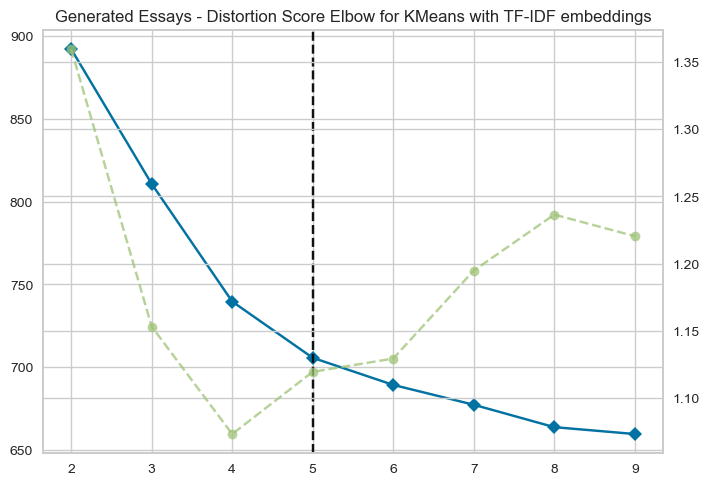

In [71]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# code for the graphs adapted from https://builtin.com/data-science/elbow-method

# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_generated)        
    
plt.title("Generated Essays - Distortion Score Elbow for KMeans with TF-IDF embeddings")
plt.show()

While the Elbow method indicates that 4 clusters are optimal, there is no desicive "elbow" at any point in the graph. Thus, we will use the Silhouette method to hopefully get more reliable results.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

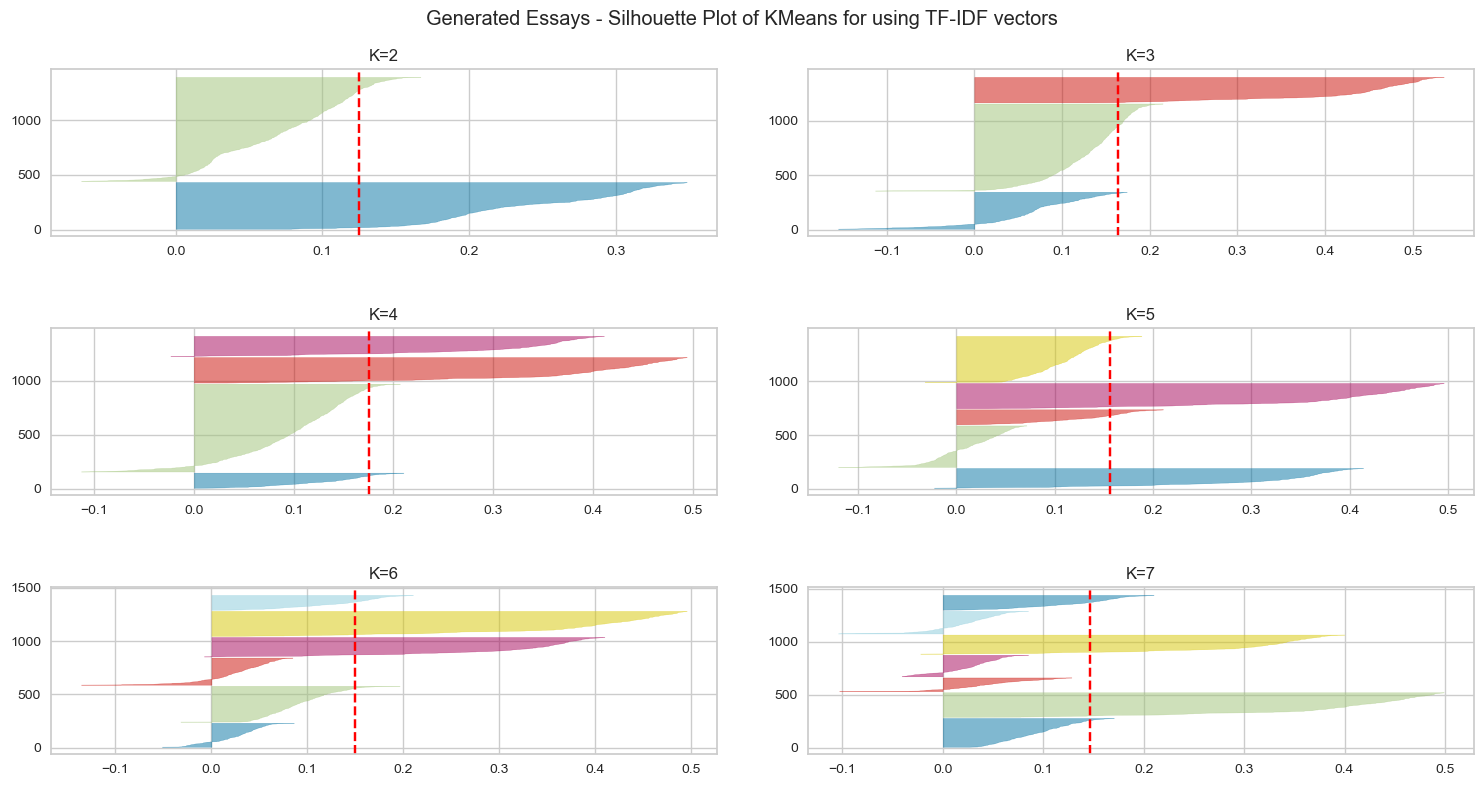

In [72]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_generated) 

fig.suptitle("Generated Essays - Silhouette Plot of KMeans for using TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

These graphs represent how similar the points in each cluster with each other compared to the ones from other clusters. The bigger the score, the more "sure" we are the point belongs in the cluster, while negative values indicate the point has probably been mis-clsutered. Each "blob" represents a cluster and the red line is the mean Silhouette score of all clusters.

We are looking for two main patterns in the graphs (we direct the reader to the [previous post](https://builtin.com/data-science/elbow-method) for details):
* All clusters must pass through the red line (all clusters must be signifcant)
* The cluster sizes should be as equal as possible.

Taking into account the two criteria, the optimal clustering for generated essays is $K=2$.

#### Determining the clusters

In order to qualitatetively assess the clustering we need to take a look at the clusters ourselves. The easiest and most reliable way is to print out a sample of each cluster and compare them.

In [73]:
def print_clusters(clusters, data_df, n_samples=2):
    for cluster in np.unique(clusters):
        print("=" * 100)
        print(f"Cluster {cluster}")
        for text in data_df[clusters==cluster].sample(n_samples).text:
            print("\t\t", text)

In [74]:
km = KMeans(n_clusters=2, 
            init="k-means++", 
            random_state=42, 
            n_init=10)
generated_clusters = km.fit_predict(x_generated)
print_clusters(generated_clusters, generated_df)

Cluster 0
		 dear senator,

i am writing to you today to express my support for keeping the electoral college as the method for electing the president of the united states. i believe that the electoral college is a fair and representative system that ensures that all states have a voice in the presidential election.

the electoral college is a system in which each state is allocated a number of electors equal to its number of u.s. representatives and senators. these electors are chosen by the voters in each state, and they are responsible for casting the votes that elect the president.

the electoral college is designed to ensure that all states have a say in the presidential election. this is important because it prevents a small number of states from dominating the election. for example, if the election were decided by popular vote, the candidates would only need to campaign in a handful of states with large populations. this would leave the voters in smaller states with little or no

It looks like the essays have been clustered according to their prompt, which confirms our intuition.

### Clustering Human Essays

#### Determining the number of clusters

We begin with the Elbow method, just like before.

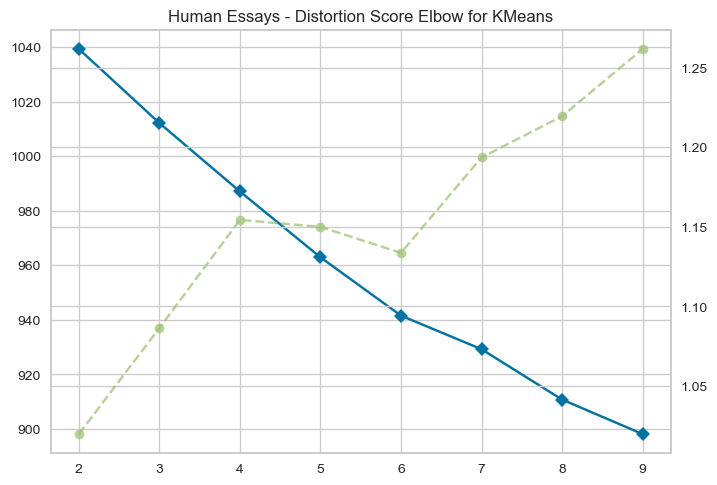

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_human)        
    
plt.title("Human Essays - Distortion Score Elbow for KMeans")
plt.show()

This is an even more perplexing elbow graph, so we turn to Silhouette score to get a better picture.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

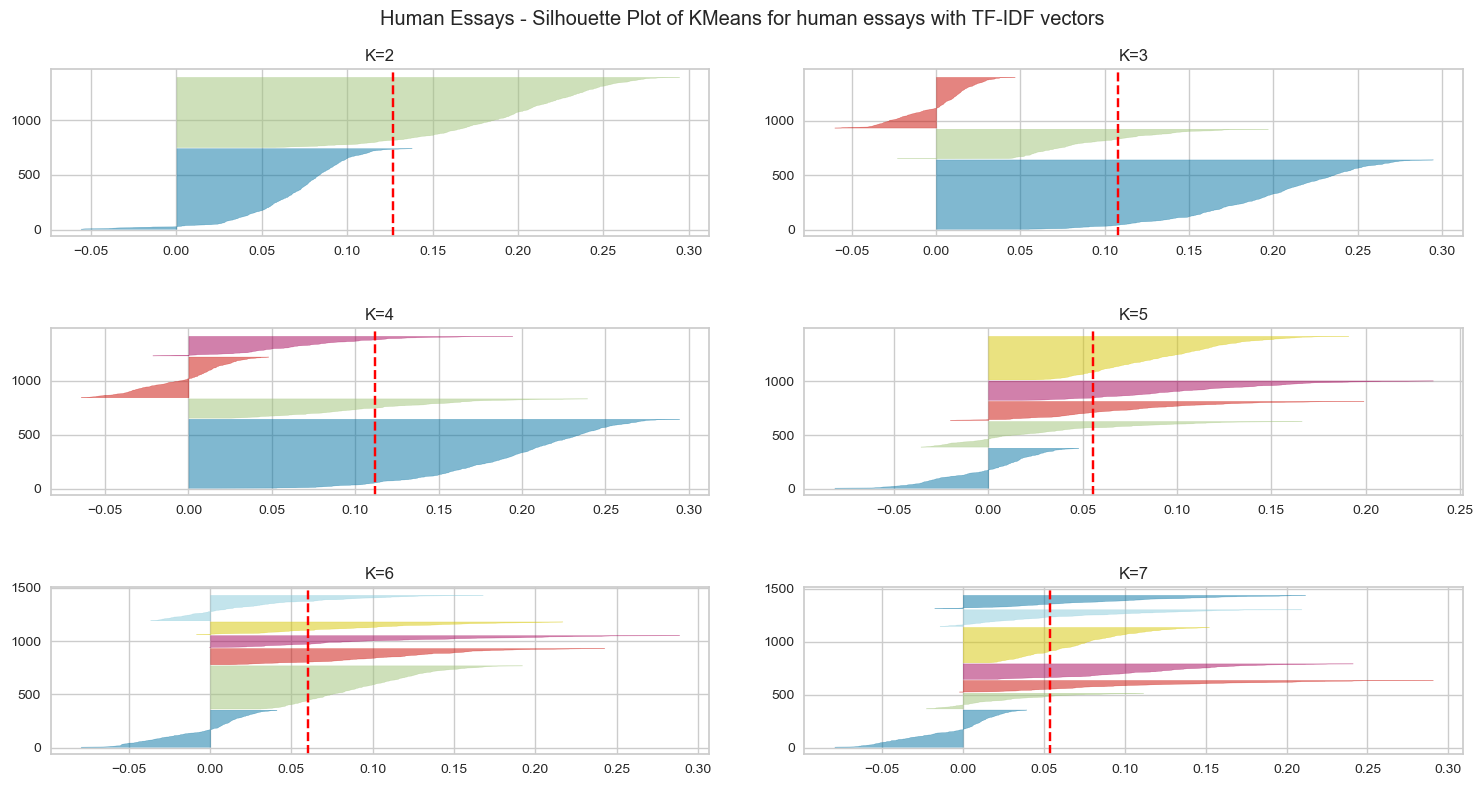

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans for human essays with TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

While we could accept $K=2$ for the same merits as in the generated essays, we must acknowledge that the clustering is much more difficult in our case. A probable reason for that is that the TF-IDF representation on which the clustering is based on, is insufficient for the human essays, either due to its shape in the $l$ dimensional space, or because of sparsity.

A way to circumvent this limitation is swapping the text representation to the Word2Vec embeddings. While probably insufficient for classification, their low dimensionality and their much higher similarity with each other (which was determined in a previous version of this notebook) make them suitable candidates for clustering.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

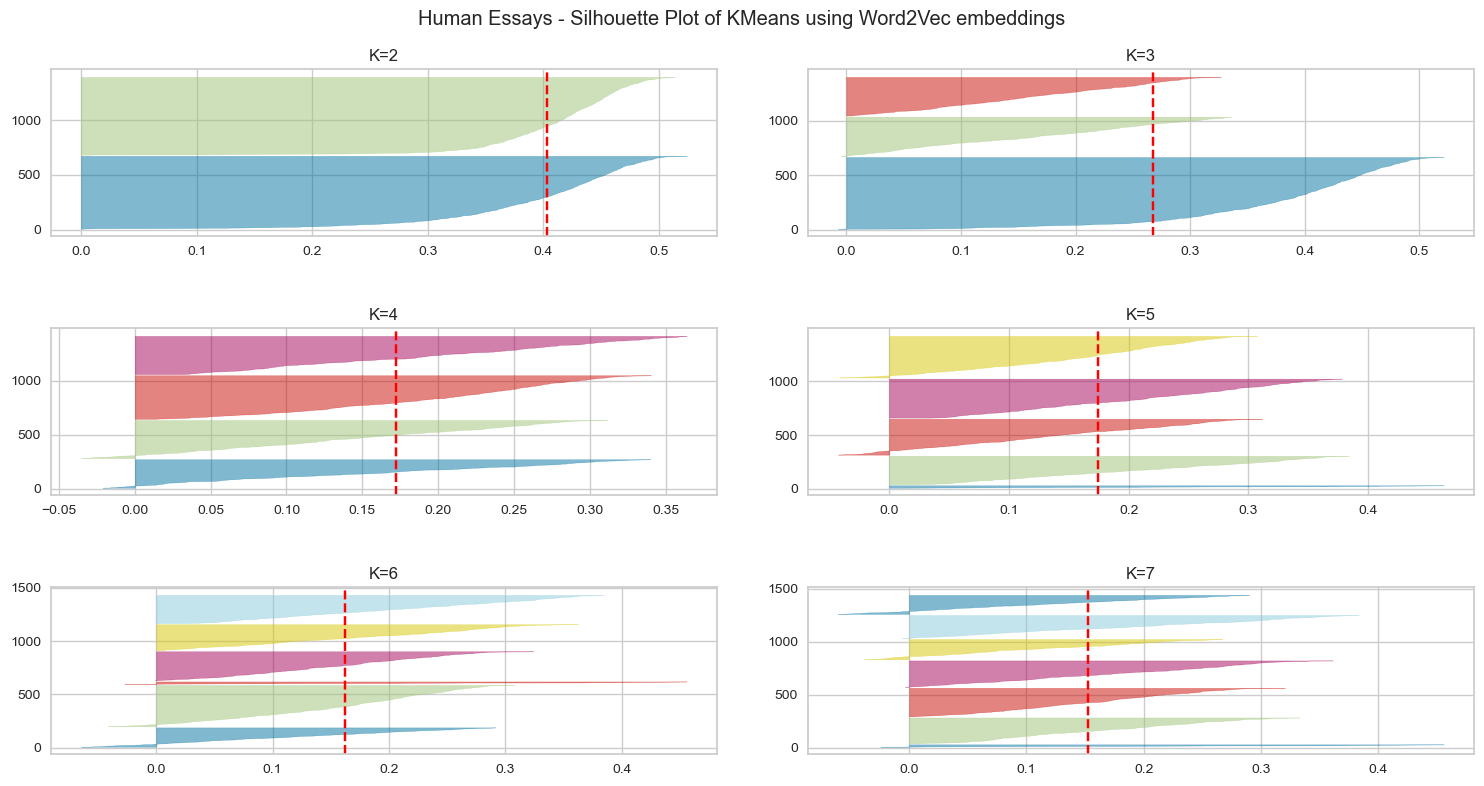

In [77]:
embed_human = np.array([x for x in df.loc[df.generated==0].embedding])
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(embed_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans using Word2Vec embeddings")
fig.tight_layout(h_pad=3, w_pad=3) 
plt.show()

This is a much clearer graph, carrying very important information; unlike the generated clusters, the human essays seem to feature underlying patterns in their 2 main clusters, making the optimal clustering $K=4$.

#### Determining the clusters

We follow the same procedure as before:

In [78]:
km = KMeans(n_clusters=4, 
                init="k-means++", 
                random_state=42, 
                n_init=10)
km = km.fit(embed_human)
human_clusters = km.predict(embed_human)
print_clusters(human_clusters, human_df)

Cluster 0
		 living in a polluted world were you cannot see the sun is not ideal, most of pollution comes from car emissions. we as people today cannot imagine what it would be like without a car, but there are advantages of not having one. there is a city in vauban, germany that residents have given up cars.

vauban is a experimental community that has "carfree" streets. "car ownership is allowed, but there are only two places to park large garages at the edge of the development, where a carowner buys a space, for 40,000, along with a home"s1p2. at first glance this experimental town might seem to be completly outrageous, but it works very well,this community has 5,500 residents. without a car life would seem to be a lot harder, moving around would require effort, but towns like this one have all the shopping and parks within walking distance of your home. stores arent spread out,so it doesn't take a 15 minute drive get to the store, but only a 5 minute walk. a resident of the town sa

Clusters 0 and 3 seem to feature prompts about car-free cities, while clusters 1 and 2 about the electoral college, corresponding to clusters 0 and 1 of the generated essay clusters respectively. 

The most notable difference between the clusters featuring the same prompts is that clusters 0 and 1 appear to stick closely to sources, citing them explicitly and often, and being much more likely to use text found in the sources themselves. Thus, we can yield a title for each cluster:

In [79]:
cluster_mapping = {0: "Cars w/sources", 
                   1: "Election w/sources",
                   2: "Election no sources",
                   3: "Cars no sources"}

### Determining the balance of the clusters

In order to get a faithful representation of the student essays by our generated dataset, we should ensure that the generated essays correspond roughly proportionally to the student clusters. 

We will cluster the generated essays according to the K-means model we trained on human essays and compare the number of essays in each cluster:

In [80]:
embed_generated = np.array([x for x in df.loc[df.generated==1].embedding])
guessed_gen_clusters = km.predict(embed_generated)

In [81]:
cluster_df = pd.DataFrame({"cluster": np.concatenate([
                                guessed_gen_clusters, 
                                human_clusters]),
                          "generated": np.concatenate([
                              np.ones_like(guessed_gen_clusters), 
                              np.zeros_like(human_clusters)])})

cluster_df.cluster = cluster_df.cluster.map(cluster_mapping)
cluster_df

,cluster,generated
0,Cars no sources,1
1,Cars no sources,1
2,Cars w/sources,1
3,Cars no sources,1
4,Cars no sources,1
...,...,...
5223,Election no sources,0
5224,Cars no sources,0
5225,Cars w/sources,0
5226,Cars no sources,0


Figured saved to ..\output\clusters.png


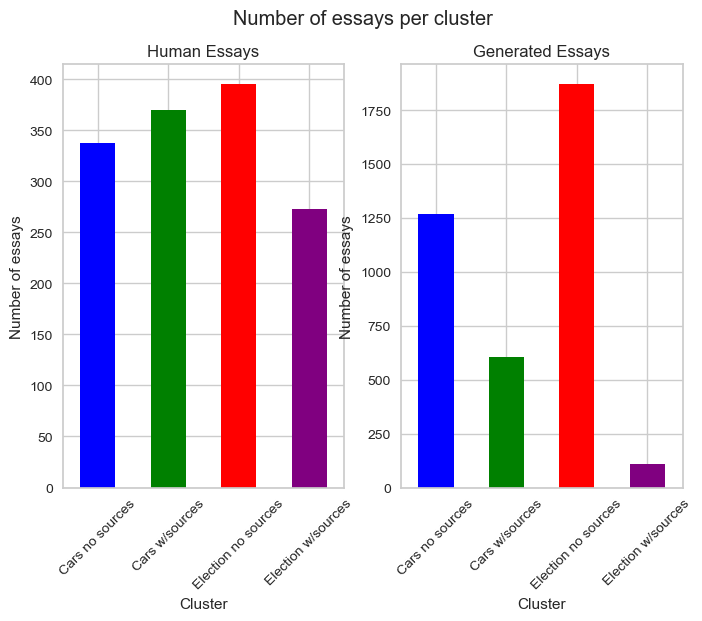

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cluster_human_df = cluster_df[cluster_df.generated == 0]
cluster_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax1)
ax1.set_title("Human Essays")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of essays")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


gen_human_df = cluster_df[cluster_df.generated == 1]
gen_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax2)
ax2.set_title("Generated Essays")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Number of essays")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

fig.suptitle("Number of essays per cluster")
save_plot("clusters.png")
plt.show()

### Dataset augmentation

We have determined that the most important weakness in our dataset is the lack of generated essays about car-free cities, which do not follow the source closely. We prompt ChatGPT with prompts explicitly against citing sources directly, and add them to our dataset.

In [83]:
extra_cars_df = create_dataset("cluster_augmentation_cars.md", 
                               prompt_id=0, 
                               llm="ChatGPT", 
                               source="Dimitris Tsirmpas")
extra_cars_df.head()

,id,text,prompt_id,generated,llm,source
0,-895843482678732734,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas
1,-6987424856428254778,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas
2,3811337436407444090,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas
3,7848712004574133491,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas
4,-8862128119693094278,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas


In [84]:
extra_cars_df.shape

(28, 6)

### Training the best classifier with the augmented data

We can now retrain our best classifier with the extra data and check whether our more balanced dataset helps improve its performace.

In [85]:
extra_cars_df_prepr = extra_cars_df.copy()
extra_cars_df_prepr.text = preprocess(extra_cars_df_prepr.text)
extra_cars_df_prepr["embedding"] = compute_embeddings(extra_cars_df_prepr.text) 

Removing stopwords...


  0%|          | 0/28 [00:00<?, ?it/s]

Computing embeddings...


  0%|          | 0/28 [00:00<?, ?it/s]

In [86]:
augmented_df_prepr = pd.concat([extra_cars_df_prepr, df])
augmented_df_prepr

,id,text,prompt_id,generated,llm,source,embedding,max
0,-895843482678732734,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
1,-6987424856428254778,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,3811337436407444090,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
3,7848712004574133491,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
4,-8862128119693094278,cluster_augmentation_cars.md,0,1,ChatGPT,Dimitris Tsirmpas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
...,...,...,...,...,...,...,...,...
5256,fe6ff9a5,there has been a fuss about the elector colleg...,1,0,Human,Competition,"[-1.4767352, 0.04409365, -2.265938, 0.2277243,...",NaN
5257,ff669174,limiting car usage has many advantages. such a...,0,0,Human,Competition,"[-0.20308205, 0.864372, -3.5353804, 0.25371215...",NaN
5258,ffa247e0,there's a new trend that has been developing f...,0,0,Human,Competition,"[-0.80689734, 0.0152280945, -2.0881786, -0.199...",NaN
5259,ffc237e9,as we all know cars are a big part of our soci...,0,0,Human,Competition,"[-0.65920925, 0.18932514, -2.4064806, -0.80102...",NaN


In [87]:
data_train, data_test = train_test_split(augmented_df_prepr,
                                        train_size=0.7,
                                        test_size=0.3,
                                         random_state=42)
data = get_data_from_text(vectorizer, data_train, data_test)

x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

In [88]:
res = cross_val_res(best_model, x_train, y_train)
print(f"Best model with TF-IDF vectors Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Best model with TF-IDF vectors Macro-F1:
 mean:0.9573, std: 0.0050


In [89]:
best_model = best_model.fit(x_train, y_train)
preds = best_model.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       421
           1       0.98      0.98      0.98      1156

    accuracy                           0.97      1577
   macro avg       0.96      0.96      0.96      1577
weighted avg       0.97      0.97      0.97      1577



We can see that our classifier hasn't significantly improved, which normally may indicate that the cluster imbalance didn't affect our dataset. However, since our test score was already close to 1, it probably indicates that our classifier cannot reach 100% performance (which for operational data would be utopic) with just a few more datapoints. 

## Exporting the full dataset

The full dataset comprises the (few) generated prompts provided to us as well as all the generated prompts we generated (even if only a subset was used for the purposes of this notebook).

Asides from meta-information included in the original dataset we also include a column representing the cluster of each essay according to the K-Means model fitted on the human essays.

In [ ]:
full_df = pd.concat([envir_df, elect_df, extra_cars_df, original_df[original_df.generated==1]])
full_df = full_df.loc[:, ["id", "text", "prompt_id", "generated"]]
full_df

In [ ]:
print("Determining clusters:")
print("\tPreprocessing...")
full_text = preprocess(full_df.text)
print("\tDone.")

print("\t", end="")
full_embeddings = compute_embeddings(full_text)
print("\tRunning K-Means...")
clusters = km.predict(np.array([x for x in full_embeddings]))
print("\tDone.")

full_df["cluster"] = clusters
full_df.cluster = full_df.cluster.map(cluster_mapping)
full_df

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.tight_layout(pad=2.0)
fig.suptitle("Augmentation Dataset Statistics")

axes[0].pie(full_df.prompt_id.value_counts(), 
        labels=["Car-Free cities", "Electoral College"], 
        textprops={'fontsize': 11},
        colors=["orange", "green"],
        autopct=f'%1.1f%%')
axes[0].set_title("Prompts")


axes[1].pie(full_df.cluster.value_counts(), 
        labels=cluster_mapping.values(), 
        textprops={'fontsize': 11},
        autopct=f'%1.1f%%')
axes[1].set_title("Category")

save_plot("augmentation_stats.png")
plt.show()

In [ ]:
csv_output(full_df, "augmentation.csv")